# An Analysis of Heart Attacks in Nigeria

## Python Section

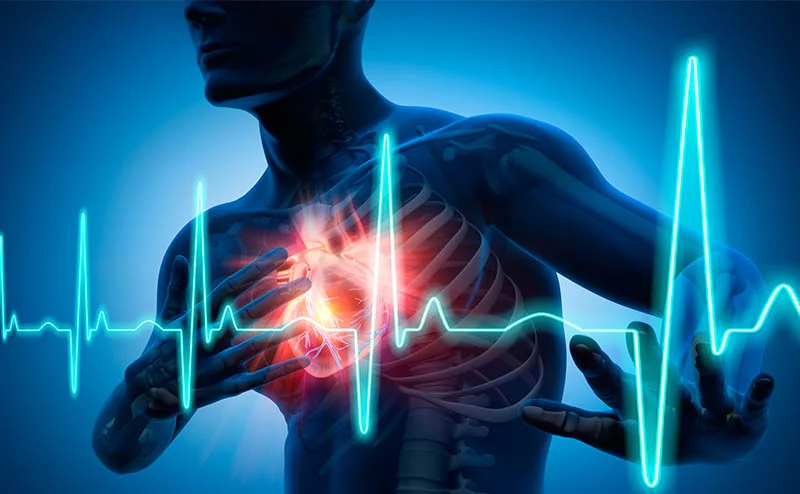

Importing everything...

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.discriminant_analysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, classification_report
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import accuracy_score

# Preprocessing

Let's start by reading in the dataset and cleaning up the columns.

In [122]:
nigeria = pd.read_csv('C:/Users/tankw/Downloads/heart_attack_nigeria_youth_vs_adult.csv')
print(nigeria.columns)

Index(['ID', 'Age', 'Gender', 'Region', 'Blood_Pressure', 'Cholesterol', 'BMI',
       'Heart_Rate', 'Exercise_Level', 'Smoking', 'Alcohol_Consumption',
       'Diabetes', 'Family_History', 'Stress_Level', 'Heart_Attack', 'Angina',
       'Heart_Disease_History', 'Diet', 'Sleep_Hours', 'Occupation',
       'Income_Level', 'Physical_Activity', 'Education_Level',
       'Marital_Status', 'Urban_Rural', 'Medication', 'Health_Awareness',
       'Daily_Water_Intake', 'Mental_Health', 'Obesity'],
      dtype='object')


In [123]:
nigeria.columns = (
    nigeria.columns
    .str.strip()          
    .str.lower()  
    .str.replace(' ', '_')  
    .str.replace('[^a-z0-9_]', '', regex=True)
)

print(nigeria.columns)

Index(['id', 'age', 'gender', 'region', 'blood_pressure', 'cholesterol', 'bmi',
       'heart_rate', 'exercise_level', 'smoking', 'alcohol_consumption',
       'diabetes', 'family_history', 'stress_level', 'heart_attack', 'angina',
       'heart_disease_history', 'diet', 'sleep_hours', 'occupation',
       'income_level', 'physical_activity', 'education_level',
       'marital_status', 'urban_rural', 'medication', 'health_awareness',
       'daily_water_intake', 'mental_health', 'obesity'],
      dtype='object')


In [124]:
nigeria.drop(columns=['id', 'urban_rural'], inplace=True)

Let's describe this data too to get a better understanding of it.

In [125]:
nigeria.shape

(50000, 28)

In [126]:
nigeria.describe()

,age,blood_pressure,cholesterol,bmi,heart_rate,stress_level,sleep_hours,health_awareness,daily_water_intake,mental_health
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,36.020400,124.730312,209.601122,26.976694,84.504340,5.516740,6.493916,2.998820,2.251884,5.477500
std,14.191716,17.987423,60.128478,6.001402,11.513936,2.873097,1.440283,1.414121,1.013574,2.864685
min,12.000000,51.500000,-26.800000,0.500000,65.000000,1.000000,4.000000,1.000000,0.500000,1.000000
25%,24.000000,112.700000,168.900000,23.000000,75.000000,3.000000,5.300000,2.000000,1.400000,3.000000
50%,36.000000,124.700000,209.600000,27.000000,85.000000,6.000000,6.500000,3.000000,2.300000,5.000000
75%,48.000000,136.900000,250.000000,31.000000,94.000000,8.000000,7.700000,4.000000,3.100000,8.000000
max,60.000000,202.400000,437.600000,53.200000,104.000000,10.000000,9.000000,5.000000,4.000000,10.000000


Are there any null values?

In [127]:
nigeria.isnull().sum()

age                          0
gender                       0
region                       0
blood_pressure               0
cholesterol                  0
bmi                          0
heart_rate                   0
exercise_level               0
smoking                      0
alcohol_consumption      35070
diabetes                     0
family_history               0
stress_level                 0
heart_attack                 0
angina                       0
heart_disease_history        0
diet                         0
sleep_hours                  0
occupation                   0
income_level                 0
physical_activity            0
education_level              0
marital_status               0
medication                   0
health_awareness             0
daily_water_intake           0
mental_health                0
obesity                      0
dtype: int64

Only for alcohol consumption; let's fill those with 'Unknown' instead.

In [128]:
nigeria.fillna('Unknown', inplace=True)

What variables correlate with each other?

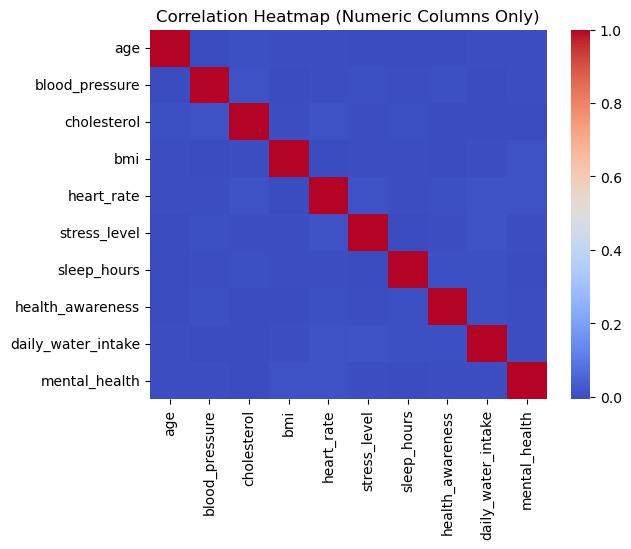

In [129]:
numeric_data = nigeria.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

Finally, let's use get_dummies for machine learning later.

In [130]:
nigeria = pd.get_dummies(nigeria, drop_first=True)

# Choosing a Machine Learning Model

First, let's separate the features (X) and target variable (Y). Then, we'll split the dataset so 80% is used as the training set, while 20% is used as the validation set.

In [131]:
X = nigeria.drop('heart_attack', axis=1)
Y = nigeria['heart_attack']

X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=0.20, stratify=Y, random_state=1
)

I imagine this dataset is imbalanced, since having a heart attack is more rare than not having one. Let's check using value_counts.

In [132]:
print(Y.value_counts())

heart_attack
False    45014
True      4986
Name: count, dtype: int64


Just as expected, only ~10% of people in the dataset had a heart attack. We can implement SMOTEEN, a mix of SMOTE and ENN, to fix this imbalance. SMOTE will generate synthetic examples for the minority sample to balance the dataset, and ENN will remove samples misclassified by their nearest neighbor (it usually removes from the majority). After all, it's more important to be right when it matters than to be accurate in life or death situations like this.

In [133]:
smote_enn = SMOTEENN(random_state=1)
X_train_resampled, Y_train_resampled = smote_enn.fit_resample(X_train, Y_train)

print("Class distribution after resampling:")
print(pd.Series(Y_train_resampled).value_counts())

Class distribution after resampling:
heart_attack
True     35481
False    18471
Name: count, dtype: int64


Now, in the training dataset, heart-attack cases are overrepresented to ensure there are minimal false negatives. Let's move on to finding a supervised model. We'll find the cross-validation accuracies, testing set accuracies, and f1 scores, then display graphs for each.

Testing model cross-validation accuracies...
Linear Discriminant Analysis: 0.884360
K-Nearest Neighbors: 0.927843
Decision Tree: 0.848550
Naive Bayes: 0.840173
Random Forest: 0.922783
XGBoost: 0.917668


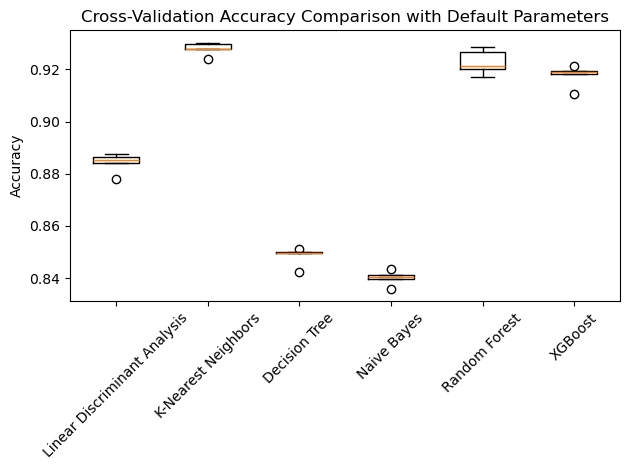


Testing model accuracies and F1-scores on validation set...
Linear Discriminant Analysis: Accuracy: 0.816900, F1-score: 0.818379
K-Nearest Neighbors: Accuracy: 0.462700, F1-score: 0.559937
Decision Tree: Accuracy: 0.707400, F1-score: 0.755633
Naive Bayes: Accuracy: 0.772700, F1-score: 0.795311
Random Forest: Accuracy: 0.887300, F1-score: 0.850159
XGBoost: Accuracy: 0.868300, F1-score: 0.841499


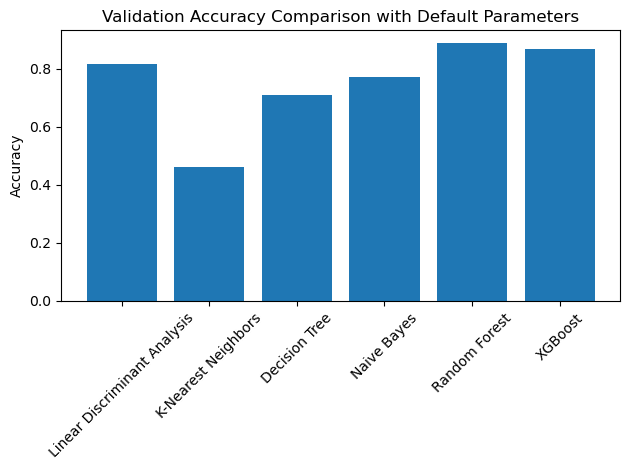

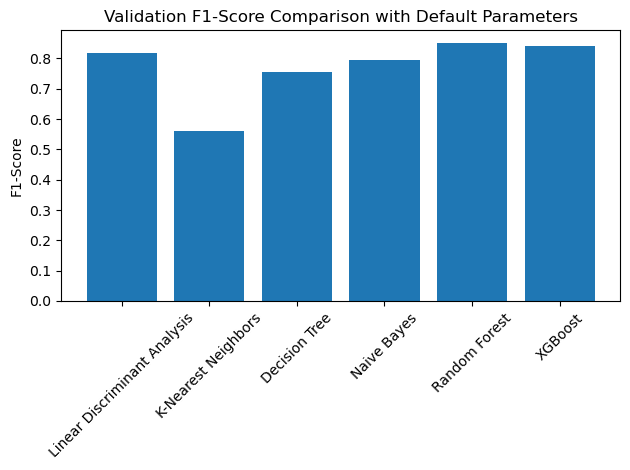

In [134]:
# ChatGPT assisted
models = [
    ('Linear Discriminant Analysis', sklearn.discriminant_analysis.LinearDiscriminantAnalysis()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier())
]

results = []
names = []

print("Testing model cross-validation accuracies...")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train_resampled, Y_train_resampled, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean():.6f}')

plt.boxplot(results, labels=names)
plt.title('Cross-Validation Accuracy Comparison with Default Parameters')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

validation_results = []
validation_f1_scores = []
validation_names = []

print("\nTesting model accuracies and F1-scores on validation set...")
for name, model in models:
    model.fit(X_train_resampled, Y_train_resampled)
    validation_accuracy = model.score(X_validation, Y_validation)
    y_pred = model.predict(X_validation)
    f1 = f1_score(Y_validation, y_pred, average='weighted')
    validation_results.append(validation_accuracy)
    validation_f1_scores.append(f1)
    validation_names.append(name)
    print(f'{name}: Accuracy: {validation_accuracy:.6f}, F1-score: {f1:.6f}')

plt.bar(validation_names, validation_results)
plt.title('Validation Accuracy Comparison with Default Parameters')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.bar(validation_names, validation_f1_scores)
plt.title('Validation F1-Score Comparison with Default Parameters')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This information was helpful, and right now it seems like Random Forest is the best choice. However, it's unclear whether the high accuracies come from legitimately good decisions or a tendency to default to 'False' when unsure. In other words, we can't be sure if the imbalance was fixed. Confusion matrices should help.

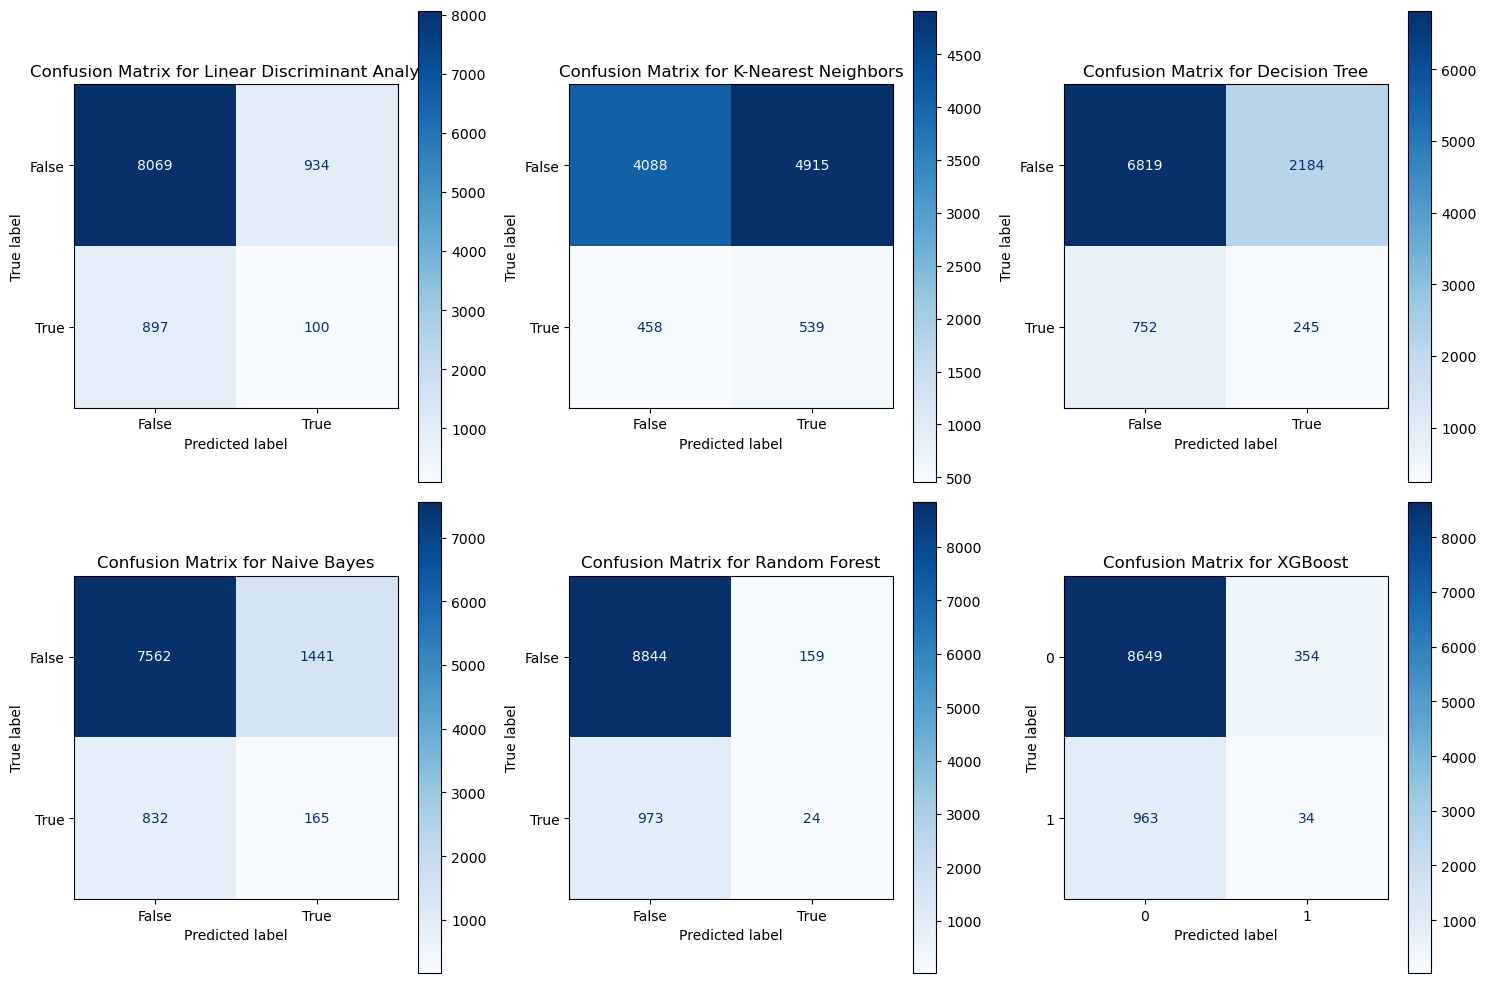

In [135]:
# ChatGPT assisted
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, (name, model) in enumerate(models):
    model.fit(np.asarray(X_train_resampled), np.asarray(Y_train_resampled))
    
    Y_pred = model.predict(np.asarray(X_validation))
    
    cm = confusion_matrix(Y_validation, Y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()

Now, it's clear that Random Forest would actually be a bad choice. In 997 heart-attack cases, the model only predicted 18 of them to be heart attacks (~2%). Same goes for XGBoost, which originally looked like a good choice. K-Nearest Neighbors does have more correctly predicted 'True' cases, but with only 50% accuracy, it's equivalent to randomly guessing. I think the best choice here is Decision Tree. It predicted 22% of heart-attack cases correctly but still has a decently high accuracy (.71) and a decently high f1 score (.75).

# Hyperparameter Optimization

Let's see if we can optimize Decision Tree's recall using grid search.

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set recall (True cases identified) with optimized Decision Tree: 0.242728
Test set accuracy with optimized Decision Tree: 0.704700


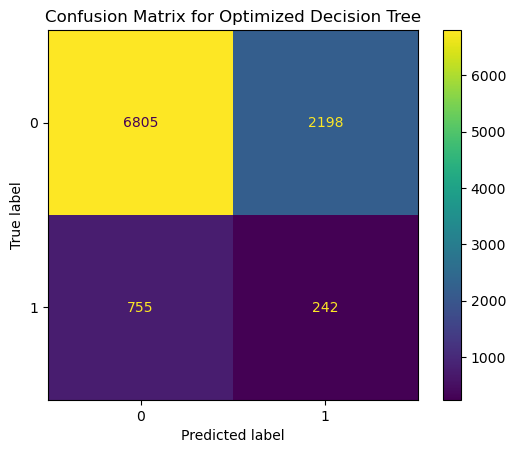

In [136]:
# Stack Overflow assisted
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=kfold, scoring='recall', n_jobs=-1)

grid_search.fit(X_train_resampled, Y_train_resampled)

print("Best parameters found:", grid_search.best_params_)

best_dt = grid_search.best_estimator_
Y_pred = best_dt.predict(X_validation)
test_recall = recall_score(Y_validation, Y_pred, pos_label=1)
test_accuracy = accuracy_score(Y_validation, Y_pred)
print(f"Test set recall (True cases identified) with optimized Decision Tree: {test_recall:.6f}")
print(f"Test set accuracy with optimized Decision Tree: {test_accuracy:.6f}")

cm = confusion_matrix(Y_validation, Y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix for Optimized Decision Tree')
plt.show()

It didn't change anything, so the best parameters are probably the most effective. Let's visualize the decision tree as well.

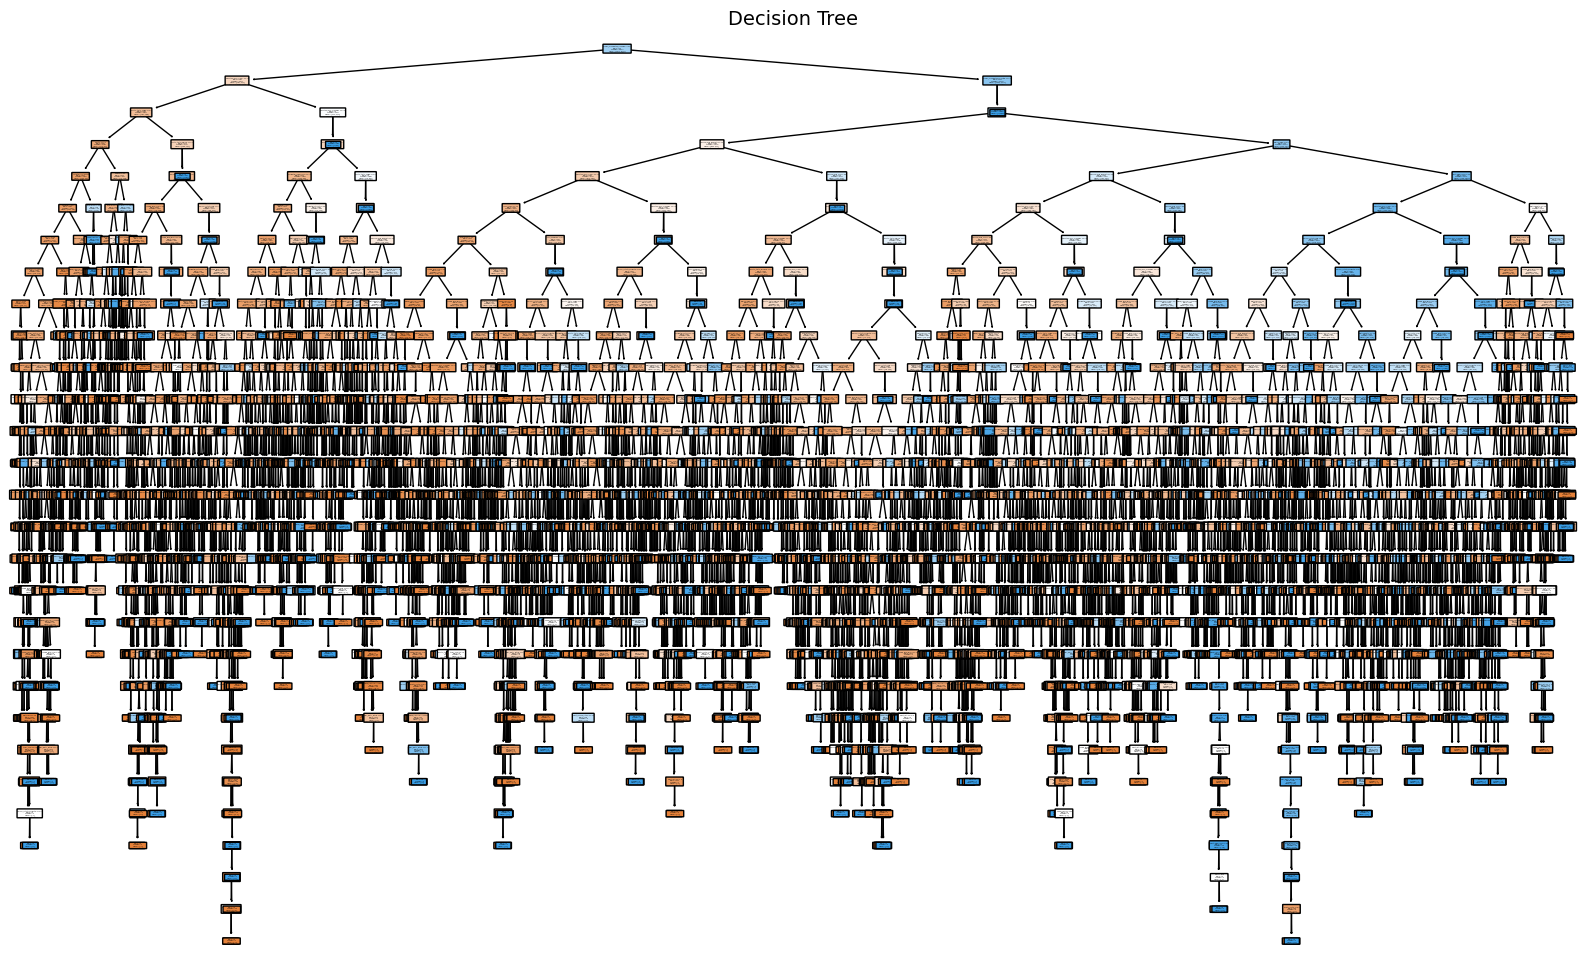

Number of nodes in the tree: 9073
Depth of the tree: 28


In [137]:
dt_model = DecisionTreeClassifier(max_depth=None, random_state=1)
dt_model.fit(X_train_resampled, Y_train_resampled)

plt.figure(figsize=(20, 12))
plot_tree(
    dt_model,
    feature_names=X_train_resampled.columns,
    class_names=['No Heart Attack', 'Heart Attack'],
    filled=True,
    rounded=True,
    fontsize=1
)
plt.title("Decision Tree", fontsize=14)
plt.show()

print("Number of nodes in the tree:", dt_model.tree_.node_count)
print("Depth of the tree:", dt_model.tree_.max_depth)

# User Input

Finally, let's create a new row using entered data and then have it predict whether it thinks the person gonna have a heart attack or not. For now, here's the unhealthiest person I could think of.

In [138]:
dt_model = DecisionTreeClassifier(max_depth=None, random_state=1)
dt_model.fit(X_train_resampled, Y_train_resampled)

user_input = {
    "age": 70,
    "blood_pressure": 150.0,
    "cholesterol": 400.0,
    "bmi": 30.5,
    "heart_rate": 100,
    "smoking": True,
    "diabetes": True,
    "family_history": True,
    "stress_level": 10,
    "angina": True,
    "heart_disease_history": True,
    "sleep_hours": 5.0,
    "medication": False,
    "health_awareness": 1,
    "daily_water_intake": 1,
    "mental_health": 1,
    "obesity": True,
    "gender_Male": True,
    "gender_Other": False,
    "region_Suburban": True,
    "region_Urban": False,
    "exercise_level_Low": True,
    "exercise_level_Moderate": False,
    "alcohol_consumption_Moderate": False,
    "alcohol_consumption_Unknown": True,
    "diet_Mixed": False,
    "diet_Unhealthy": True,
    "occupation_Retired": True,
    "occupation_Student": False,
    "occupation_Unemployed": True,
    "income_level_Low": True,
    "income_level_Middle": False,
    "physical_activity_Low": True,
    "physical_activity_Moderate": False,
    "education_level_Primary": False,
    "education_level_Secondary": True,
    "marital_status_Married": False,
    "marital_status_Single": True,
    "marital_status_Widowed": False
}

user_data = pd.DataFrame([user_input])

user_data = user_data[X_train_resampled.columns]

prediction = dt_model.predict(user_data)[0]

if prediction == 1:
    print(f"The model predicts that the person is LIKELY to have a heart attack (take this with a grain of salt).")
else:
    print(f"The model predicts that the person is NOT likely to have a heart attack.")

The model predicts that the person is LIKELY to have a heart attack (take this with a grain of salt).


Here's data for a typical 17-year-old:

In [139]:
user_input = {
    "age": 17,
    "blood_pressure": 120.0,
    "cholesterol": 200.0,
    "bmi": 21.0,
    "heart_rate": 70,
    "smoking": False,
    "diabetes": False,
    "family_history": False,
    "stress_level": 3,
    "angina": False,
    "heart_disease_history": False,
    "sleep_hours": 8.0,
    "medication": False,
    "health_awareness": 4,
    "daily_water_intake": 3.0,
    "mental_health": 7,
    "obesity": False,
    "gender_Male": True,
    "gender_Other": False,
    "region_Suburban": True,
    "region_Urban": False,
    "exercise_level_Low": False,
    "exercise_level_Moderate": True,
    "alcohol_consumption_Moderate": False,
    "alcohol_consumption_Unknown": False,
    "diet_Mixed": True,
    "diet_Unhealthy": False,
    "occupation_Retired": False,
    "occupation_Student": True,
    "occupation_Unemployed": False,
    "income_level_Low": True,
    "income_level_Middle": False,
    "physical_activity_Low": False,
    "physical_activity_Moderate": True,
    "education_level_Primary": False,
    "education_level_Secondary": True,
    "marital_status_Married": False,
    "marital_status_Single": True,
    "marital_status_Widowed": False
}

user_data = pd.DataFrame([user_input])

user_data = user_data[X_train_resampled.columns]

prediction = dt_model.predict(user_data)[0]

if prediction == 1:
    print(f"The model predicts that the person is LIKELY to have a heart attack (take this with a grain of salt).")
else:
    print(f"The model predicts that the person is NOT likely to have a heart attack.")

The model predicts that the person is NOT likely to have a heart attack.


# Conclusion

Just as Chase and Nick discovered while working with R, I realized how difficult it is to predict whether someone will have a heart attack, even with 28 columns of data covering health indicators, personal habits, and blood metrics. It seems like heart attacks instead come from uncontrollable and undetectable factors like genetics, environment, and underlying conditions, which machine learning algorithms can't test on. This is most likely why seemingly healthy individuals can experience sudden cardiac events just as easily as unhealthy ones, despite being in great shape, never smoking/drinking, and eating clean. While our model did offer some insights (covered in the slideshow), its limitations were clear, and I wouldn’t trust it in a hospital setting. Overall, this project was a humbling reminder of how much more there is to learn about cardiology and why continued research in this field is so critical.